# Sentiment Analysis on Yelp Data

## Importing Libraries and Dependencies

In [124]:
import os
import pickle
import seaborn as sns
import numpy as np
import pandas as pd

from wordcloud import WordCloud

from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [125]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig = plt.gcf()
fig.set_size_inches(12, 8)
%matplotlib inline


## Importing Data

In [126]:
df = pd.DataFrame();
with (open('model_data.pickle','rb')) as openfile:
    df = pickle.load(openfile)
df.head()

,business_id,business_stars,review_count,categories,user_id,text,review_stars,restaurants_table_service,wifi,bike_parking,...,alcohol,good_for_meal,dogs_allowed,restaurants_take_out,noise_level,restaurants_attire,restaurants_delivery,good_for_kids,good_for_dancing,music
0,6iYb2HFDywm3zjuRg0shjw,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",93z0yh-sUpGZS-cSKu6xxA,Stopped in on a busy Friday night. Despite the...,5,True,free,True,...,beer_and_wine,"{'dessert': False, 'latenight': False, 'lunch'...",False,True,average,casual,None,None,None,True
1,6iYb2HFDywm3zjuRg0shjw,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Q_CZIvnsDHjpls-EPzzG7Q,Went there about 1 PM on a Monday. It wasn't ...,2,True,free,True,...,beer_and_wine,"{'dessert': False, 'latenight': False, 'lunch'...",False,True,average,casual,None,None,None,True
2,6iYb2HFDywm3zjuRg0shjw,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",rqxTSFFj5fZNmabY1fmTlw,This was the place the be on Friday Night! If ...,5,True,free,True,...,beer_and_wine,"{'dessert': False, 'latenight': False, 'lunch'...",False,True,average,casual,None,None,None,True
3,6iYb2HFDywm3zjuRg0shjw,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",vNPxlt5f50q0e2nVAScW3Q,Went to this place with my family over the wee...,4,True,free,True,...,beer_and_wine,"{'dessert': False, 'latenight': False, 'lunch'...",False,True,average,casual,None,None,None,True
4,6iYb2HFDywm3zjuRg0shjw,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",eXRC79iX60xwA1UuGRuWNg,"Stopped on a midweek afternoon, and so glad th...",4,True,free,True,...,beer_and_wine,"{'dessert': False, 'latenight': False, 'lunch'...",False,True,average,casual,None,None,None,True


In [127]:
review_data = df[['review_stars','text']].sample(n=2000000)

In [128]:
review_data.head()

,review_stars,text
6926839,5,"Very good servise and very reasonable price, h..."
5866192,5,Lee is fantastic !! Decided to try somewhere n...
4050179,1,Smallish updated rooms but horrendous customer...
3838243,4,This was my first time dining at this restaura...
4842050,1,Buyer beware- I was simply looking for informa...


## Preparing Labels
I am analyzing and preparing the labels for be used for training.

In [129]:
df.review_stars.value_counts()

5    3814532
4    1920037
1    1262800
3     926656
2     711378
Name: review_stars, dtype: int64

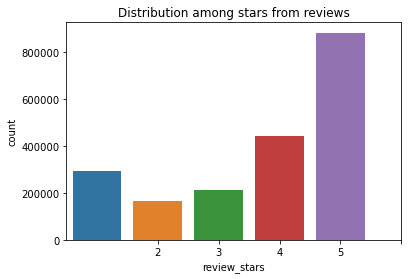

<Figure size 216x288 with 0 Axes>

In [130]:
sns.countplot(data=review_data, x="review_stars")
plt.xticks([1,2,3,4,5])
plt.title("Distribution among stars from reviews")
plt.figure(figsize=(3,4))
plt.show()

📝 Author's Notes:

The distribution of ratings is skewed left and is imbalanced.

In [131]:
review_data['review_stars'].describe()

count    2.000000e+06
mean     3.731185e+00
std      1.457113e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: review_stars, dtype: float64

In [132]:
def simplify_ratings(x):
    if x < 3:
        x = 0
    elif x == 3:
        x = 1
    elif x > 3:
        x = 2
    return x
review_data['review_stars'] = review_data['review_stars'].apply(lambda x: simplify_ratings(x) )

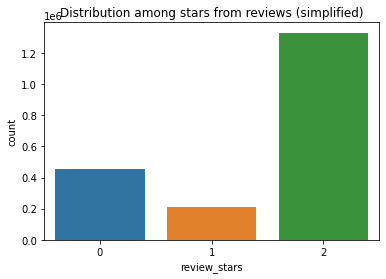

<Figure size 216x288 with 0 Axes>

In [133]:
sns.countplot(data=review_data, x="review_stars")
plt.xticks([0,1,2])
plt.title("Distribution among stars from reviews (simplified)")
plt.figure(figsize=(3,4))
plt.show()

📝 Author's Notes:

Its is clear that the data skews in favor of positive ratings.

In [134]:
review_data["review_stars"].value_counts()

2    1328595
0     457188
1     214217
Name: review_stars, dtype: int64

📝 Author's Notes:

There is an inbalance in the results of the review. This may cause issues when predicting neutral reviews.

## Preparing Text

In [135]:
# What is the longest review?
review_data['text'].str.len().max()

5000

In [136]:
#What is the the shortest review?
review_data['text'].str.len().min()

1

📝 Author's Note: 

I will be removing all reviews less than 5 characters due to it not providing enough context to the business.

In [137]:
review_data['length'] = review_data['text'].str.len()

In [163]:
review_data['length'].describe()

count    2.000000e+06
mean     6.054779e+02
std      5.583165e+02
min      1.000000e+00
25%      2.440000e+02
50%      4.360000e+02
75%      7.700000e+02
max      5.000000e+03
Name: length, dtype: float64

Text(0.5, 1.0, 'Distribution of the length of reviews')

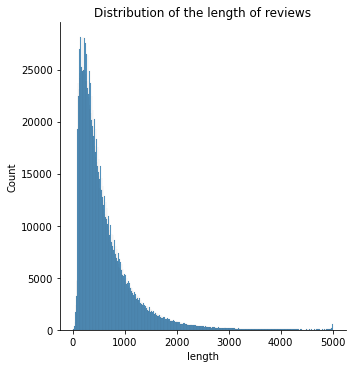

In [138]:
sns.displot(data=review_data, x='length')
plt.title('Distribution of the length of reviews')

In [139]:
review_data['length'].mean()

605.477913

Lets analyze the left side of the distribution

In [140]:
trimmed_review_data = review_data[review_data['length'] < 2000]

In [141]:
trimmed_review_data['length'].min()

1

Text(0.5, 1.0, 'Distribution of the length of reviews (Trimmed)')

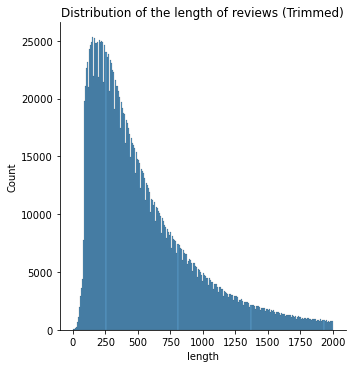

In [142]:
sns.displot(data=trimmed_review_data, x='length')
plt.title('Distribution of the length of reviews (Trimmed)')

In [143]:
trimmed_review_data['length'].mean()

539.615749192131

📝 Author's Notes:

An overwhelming number of reviews are found in between the 100 and 2000. Will having longer reviews help out in generating a better model? 

## Start Data Processing
Lets convert both text and labels to a point where we can start preparing to train our model

### Importing custom files to clean up text

In [144]:
# Importing custom cleanup files to process the text
from CleanUpFiles.ntlk_clean_text import clean_text

### Cleaning Up Text

In [145]:
clean_text("Hello World, \n\t was I'll be walking through the night. I can't be here by morning!")

'hello world i walking night i morning'

📝 Author's Notes:

**Update**  I changed the order of things on the ntlk file. That fixed the 'wa' issue.

There is a weird thing that removes contractions that could affect negative words

In [146]:
review_data_cleaned = pd.DataFrame()
review_data_cleaned['label'] = review_data['review_stars'].copy()

In [147]:
%%time
review_data_cleaned['text'] = review_data['text'].apply(lambda x: "".join(clean_text(x)))

Wall time: 57min 45s


In [148]:
review_data_cleaned.head()

,label,text
6926839,2,very good servise reasonable price highly reco...
5866192,2,lee fantastic decided try somewhere new walked...
4050179,0,smallish updated room horrendous customer serv...
3838243,2,this first time dining restaurant i pleasantly...
4842050,0,buyer beware i simply looking information i se...


📝 Author's Notes:

Remove all rows that are empty strings. Any strings just containing whitespaces will be striped down. Running a calculation run will identify any strings that are empty and then drop them.

In [149]:
review_data_cleaned['text'] = review_data_cleaned['text'].apply(lambda x: x.strip())

In [150]:
review_data_cleaned['length'] = review_data_cleaned['text'].str.len()

In [151]:
review_data_cleaned['text'].str.len().min()

0

In [152]:
review_data_cleaned['length'].sort_values(ascending=True)

8562983       0
270905        0
5591512       0
5561797       0
6318915       0
           ... 
3425780    3867
7753889    3897
1367492    3993
8304664    4647
7220122    4670
Name: length, Length: 2000000, dtype: int64

In [153]:
review_data_cleaned = review_data_cleaned[review_data_cleaned.length != 0]

In [154]:
review_data_cleaned['text'].str.len().min()

1

In [155]:
review_data_cleaned.shape

(1999770, 3)

In [156]:
review_data_cleaned.head()

,label,text,length
6926839,2,very good servise reasonable price highly reco...,158
5866192,2,lee fantastic decided try somewhere new walked...,772
4050179,0,smallish updated room horrendous customer serv...,204
3838243,2,this first time dining restaurant i pleasantly...,965
4842050,0,buyer beware i simply looking information i se...,931


In [157]:
review_data_cleaned['text'].min()

'a'

📝 Author's Notes:

I see there are left over characters such as "a" and what is left of I am assuming contractions.

### Preparing Text for Word Cloud

In [158]:
good_reviews_df = pd.DataFrame()
bad_reviews_df = pd.DataFrame()
neutral_reviews_df = pd.DataFrame()

good_reviews_df['text'] = review_data_cleaned.loc[review_data_cleaned['label'] == 2].text
neutral_reviews_df['text'] = review_data_cleaned.loc[review_data_cleaned['label'] == 1].text
bad_reviews_df['text'] = review_data_cleaned.loc[review_data_cleaned['label'] == 0].text

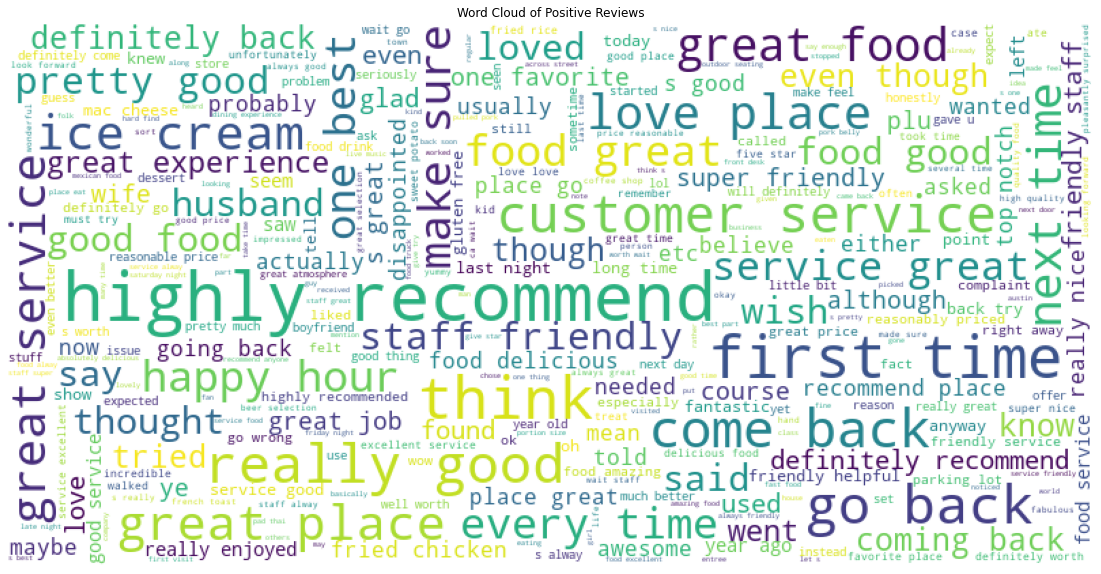

In [159]:
text = " ".join(review for review in good_reviews_df['text'])
wordcloud = WordCloud(max_font_size=50, max_words=300, background_color="white", width=800, height=400).generate(text)

plt.figure( figsize=(20,10) )
plt.title("Word Cloud of Positive Reviews")
plt.axis('off')
plt.imshow(wordcloud)

📝 Author's Notes:

**Update** The order the methods I used to clean the text caused the issue below.

**Update** "wa" comes from "was", I need to figure out why that is...

This looks good, not sure where 'wa' is coming from. Need to look into it. Probably how I am cleaning the text.

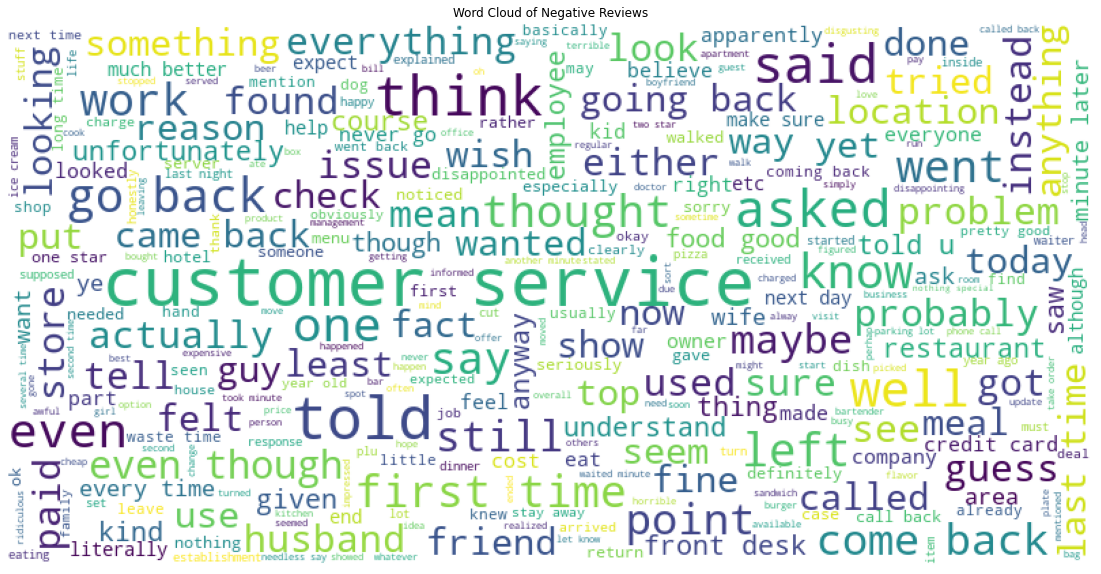

In [160]:
text = " ".join(review for review in bad_reviews_df['text'])
wordcloud = WordCloud(max_font_size=50, max_words=300, background_color="white", width=800, height=400).generate(text)
plt.figure( figsize=(20,10) )
plt.title("Word Cloud of Negative Reviews")
plt.axis('off')
plt.imshow(wordcloud)

📝 Author's Notes:

**Update** Updating the text fixed the issue below. Negative isn't as pronounced as I would like it...

There is not obvious negative words on this list. Which is wierd since last time there were noticible words associated with negative reviews such as 'horrible', 'bad', etc...

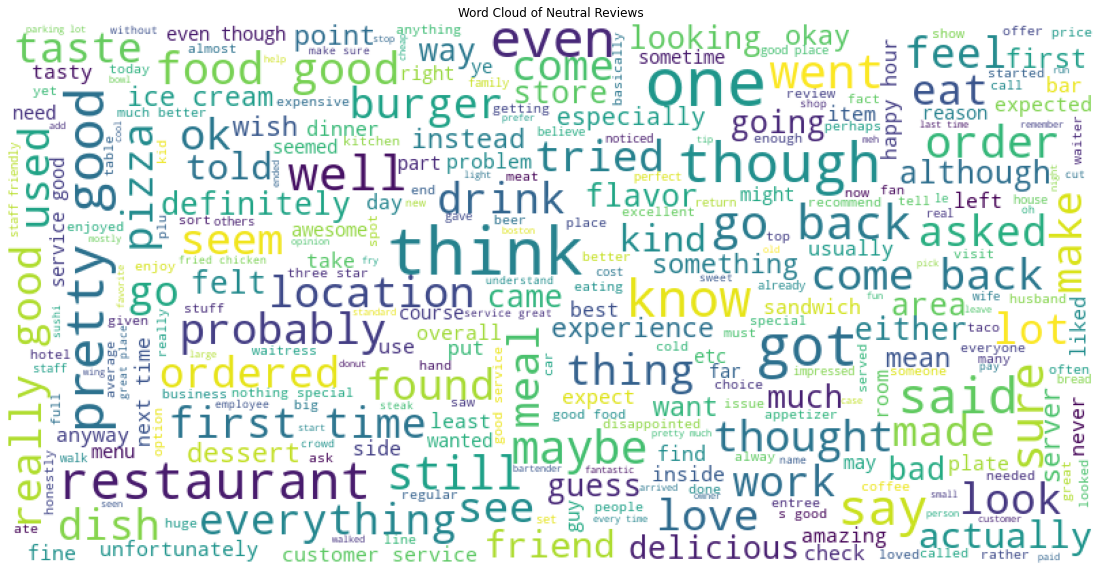

In [161]:
text = " ".join(review for review in neutral_reviews_df['text'])
wordcloud = WordCloud(max_font_size=50, max_words=300, background_color="white",width=800, height=400).generate(text)
plt.figure( figsize=(20,10) )
plt.title("Word Cloud of Neutral Reviews")
plt.axis('off')
plt.imshow(wordcloud)

📝 Author's Note: 

**Update** Changing the order of the cleaning text fixed the below issue.

**Update** Removing contractions did remove certain characters. the only thing left over are 's' and 'wa'

⚠️ There seems to be a lot of broken words such as "n t", "ve", "s","m", etc. Not sure if these are left overs from contractions or other words?

## Saving Cleaned Data to be used for Model Training

In [51]:
review_data_cleaned.to_pickle('cleaned_data200k.pkl')

## Load Data for Model Training
Load already cleaned data to save time not running the first half of this notebook.

In [54]:
clean_data_df = pd.read_pickle('cleaned_data200k.pkl')
X = clean_data_df['text'].values
y = clean_data_df['label'].values

## Use for training a model
These are used to train individual models to be saved and used later on

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=101)

## Preparing for Model Training


In [56]:
def strat_cross_val(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print(classification_report(Y[test],prediction))
        print('-'*50)
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [57]:
def display_confusion_matrix(y_test,y_pred):
    df_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted False", "Predicted Neutral","Predicted True"], 
             index=["Actual False","Actual Neutral", "Actual True"])
    df_matrix.style.background_gradient(cmap='Blues')
    display(df_matrix)

### Building Pipelines

In [81]:
tfidfVec = TfidfVectorizer(stop_words=None, max_features=10000,ngram_range=(1, 3))

In [82]:
logRegress_pipeline = Pipeline([
    ('vec', tfidfVec),
    ('clf', LogisticRegression(solver='liblinear'))
])

In [83]:
multiNB_pipeline = Pipeline([
    ('vec',tfidfVec),
    ('clf',naive_bayes.MultinomialNB())
])

In [84]:
svc_pipeline = Pipeline([
    ('vec',tfidfVec),
    ('clf',LinearSVC())
])

## Preparing for Testing Model
This will print out a nice looking output when testing a model

In [94]:
class color:
   CYAN = '\033[96m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
def print_results(res,reviews):
    for index, rating in enumerate(res):
        if rating == 0:
            print(f"🧠 Predicts:{color.BOLD} {color.RED} 😡 Negative Review {color.END}")
        elif rating == 1:
            print(f"🧠 Predicts:{color.BOLD} {color.YELLOW} 😐 Neutral Review {color.END}")
        elif rating == 2:
            print(f"🧠 Predicts:{color.BOLD} {color.GREEN} 🙂 Positive Review {color.END}")
        else:
            print(f"🧠 Predicts:{color.BOLD} {color.CYAN} 💣 UNKNOWN RESULT {color.END}")
        print(f"\t💬 \"{reviews[index]}\"\n")
        
        
new_test_data = [
    "This was the worst place I've ever eaten at. The staff was rude and did not take my order until after i pulled out my wallet.",
    "It was ok, I guess",
    "I had a pleasent time with kimberly at the granny shack. The food was amazing and very family friendly.",
]

## Model Training
The following segments are broken up as follow:
* Logistic Regression
* Multinomial Naive Bayes
* Linear SVC
* ~~~Random Forest Classifier~~~ ⚠️ Removed to it being too costly

Each of these will undergo stratified cross validation to get an average accuracy score and then train one model for testing.
### Logistic Regression

In [123]:
%%time
strat_cross_val(5, X, y, logRegress_pipeline, 'macro')

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      9197
           1       0.58      0.24      0.34      4283
           2       0.89      0.97      0.93     26515

    accuracy                           0.86     39995
   macro avg       0.77      0.69      0.70     39995
weighted avg       0.84      0.86      0.84     39995

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      9197
           1       0.57      0.24      0.34      4283
           2       0.89      0.97      0.93     26515

    accuracy                           0.86     39995
   macro avg       0.77      0.69      0.70     39995
weighted avg       0.84      0.86      0.84     39995

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      9197
           1       0.58    

In [101]:
%%time
logRegress_pipeline.fit(X_train,y_train)

Wall time: 1min 2s


Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('clf', LogisticRegression(solver='liblinear'))])

In [102]:
%%time
y_pred_logRegress = logRegress_pipeline.predict(X_test)

Wall time: 7.51 s


In [103]:
print(classification_report(y_test,y_pred_logRegress))
display_confusion_matrix(y_test,y_pred_logRegress)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85     13678
           1       0.56      0.24      0.34      6299
           2       0.89      0.97      0.93     40015

    accuracy                           0.87     59992
   macro avg       0.76      0.69      0.70     59992
weighted avg       0.85      0.87      0.85     59992



,Predicted False,Predicted Neutral,Predicted True
Actual False,11713,591,1374
Actual Neutral,1557,1519,3223
Actual True,762,580,38673


In [104]:
print_results(logRegress_pipeline.predict(new_test_data), new_test_data)

🧠 Predicts:  😡 Negative Review 
	💬 "This was the worst place I've ever eaten at. The staff was rude and did not take my order until after i pulled out my wallet."

🧠 Predicts:  😐 Neutral Review 
	💬 "It was ok, I guess"

🧠 Predicts:  🙂 Positive Review 
	💬 "I had a pleasent time with kimberly at the granny shack. The food was amazing and very family friendly."



In [105]:
file_name_logReg = "./models/logReg_model.sav"
pickle.dump(logRegress_pipeline,open(file_name_logReg,'wb'))

📝 Author's Notes:

This model had decent performance training and produced good results. 

### MultinomialNB

In [106]:
%%time
strat_cross_val(5, X, y, multiNB_pipeline, 'macro')

              precision    recall  f1-score   support

           0       0.81      0.74      0.78      9197
           1       0.48      0.14      0.21      4283
           2       0.84      0.96      0.90     26515

    accuracy                           0.82     39995
   macro avg       0.71      0.62      0.63     39995
weighted avg       0.80      0.82      0.80     39995

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      9197
           1       0.47      0.13      0.21      4283
           2       0.84      0.96      0.90     26515

    accuracy                           0.82     39995
   macro avg       0.71      0.61      0.63     39995
weighted avg       0.80      0.82      0.80     39995

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      9197
           1       0.49    

In [107]:
%%time
multiNB_pipeline.fit(X_train,y_train)

Wall time: 58.1 s


Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('clf', MultinomialNB())])

In [108]:
%%time
y_pred_multiNB = multiNB_pipeline.predict(X_test)

Wall time: 7.92 s


In [109]:
print(classification_report(y_test,y_pred_multiNB))
display_confusion_matrix(y_test,y_pred_multiNB)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     13678
           1       0.48      0.14      0.21      6299
           2       0.84      0.96      0.90     40015

    accuracy                           0.83     59992
   macro avg       0.71      0.62      0.63     59992
weighted avg       0.80      0.83      0.80     59992



,Predicted False,Predicted Neutral,Predicted True
Actual False,10231,729,2718
Actual Neutral,1058,870,4371
Actual True,1314,215,38486


In [110]:
print_results(multiNB_pipeline.predict(new_test_data), new_test_data)

🧠 Predicts:  😡 Negative Review 
	💬 "This was the worst place I've ever eaten at. The staff was rude and did not take my order until after i pulled out my wallet."

🧠 Predicts:  😡 Negative Review 
	💬 "It was ok, I guess"

🧠 Predicts:  🙂 Positive Review 
	💬 "I had a pleasent time with kimberly at the granny shack. The food was amazing and very family friendly."



In [111]:
file_name_multiNB = "./models/multiNB_model.sav"
pickle.dump(multiNB_pipeline,open(file_name_multiNB,'wb'))

📝 Author's Notes:

**Update** Found the reason, it had to do with TFIDFVectorizer max_features. I had it empty to take into consideration for the whole corpus which caused issues with MultinomialNB. I limited max_features to 10,000 and reran this section which produced better results.

⚠️ For some reason this model went from good to terrible. Did changing the text_clean up program and increasing the number of testing data cause this?

### Linear SVC

In [112]:
%%time
strat_cross_val(5, X, y, svc_pipeline, 'macro')

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      9197
           1       0.55      0.26      0.36      4283
           2       0.90      0.96      0.93     26515

    accuracy                           0.86     39995
   macro avg       0.76      0.69      0.71     39995
weighted avg       0.84      0.86      0.85     39995

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      9197
           1       0.54      0.26      0.35      4283
           2       0.90      0.96      0.93     26515

    accuracy                           0.86     39995
   macro avg       0.75      0.69      0.71     39995
weighted avg       0.84      0.86      0.85     39995

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      9197
           1       0.56    

In [118]:
%%time
svc_pipeline.fit(X_train,y_train)

Wall time: 1min 1s


Pipeline(steps=[('vec',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('clf', LinearSVC())])

In [119]:
%%time
y_pred_svc = svc_pipeline.predict(X_test)

Wall time: 7.55 s


In [120]:
print(classification_report(y_test,y_pred_svc))
display_confusion_matrix(y_test,y_pred_svc)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     13678
           1       0.53      0.27      0.36      6299
           2       0.90      0.96      0.93     40015

    accuracy                           0.86     59992
   macro avg       0.75      0.70      0.71     59992
weighted avg       0.84      0.86      0.85     59992



,Predicted False,Predicted Neutral,Predicted True
Actual False,11771,727,1180
Actual Neutral,1623,1705,2971
Actual True,915,805,38295


In [121]:
print_results(svc_pipeline.predict(new_test_data), new_test_data)

🧠 Predicts:  😡 Negative Review 
	💬 "This was the worst place I've ever eaten at. The staff was rude and did not take my order until after i pulled out my wallet."

🧠 Predicts:  😐 Neutral Review 
	💬 "It was ok, I guess"

🧠 Predicts:  🙂 Positive Review 
	💬 "I had a pleasent time with kimberly at the granny shack. The food was amazing and very family friendly."



In [122]:
file_name_svm = "./models/svc_model.sav"
pickle.dump(svc_pipeline,open(file_name_svm,'wb'))

📝 Author's Notes:

This model replaced the SVM model due to it being costly. This model not only produced results faster than Linear Regression but by a slight improvement in accuracy.